In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
from src.tools.clustering import cluster_hdbscan
from src.models.tfidf import tfidf
from src.tools.dim_reduction import reduce_umap
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl
from src.tools.aggregation import aggregate_hex
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from pytorch_lightning.loggers import WandbLogger
import wandb
from src.models.autoencoder import LitAutoEncoder

tqdm.pandas()

In [3]:
cities = pd.read_csv(RAW_DATA_DIR.joinpath("cities.csv"))
cities = cities[cities["country"] == "Poland"]
cities: pd.DataFrame = cities[cities["city"] != "Świdnica"].reset_index(drop=True)
cities

,city,country
0,Wrocław,Poland
1,Warszawa,Poland
2,Kraków,Poland
3,Poznań,Poland
4,Gdańsk,Poland
5,Szczecin,Poland
6,Katowice,Poland
7,Częstochowa,Poland
8,Białystok,Poland


In [4]:
resolution = 9
buffered = True
network_type = "drive"

pbar = tqdm(cities.itertuples(), total=cities.shape[0])
edges_hex_cities = []
hexagons_cities = []
for row in pbar:
    place_name = f"{row.city},{row.country}"
    place_dir_name = get_place_dir_name(place_name)
    pbar.set_description(place_name)

    hexagon_city = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"hex_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
    hexagon_city["city"] = row.city
    hexagons_cities.append(hexagon_city)

    edges_hex_city = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"edges_{network_type}_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
    edges_hex_city["city"] = row.city
    edges_hex_cities.append(edges_hex_city)

hexagons = pd.concat(hexagons_cities, ignore_index=True).set_index("h3_id")
edges_hex = pd.concat(edges_hex_cities, ignore_index=True)
hex_agg = aggregate_hex(edges_hex.drop(columns="city"))
hex_agg_tfidf = tfidf(hex_agg)

Białystok,Poland: 100%|██████████| 9/9 [01:30<00:00, 10.05s/it]


In [6]:
X = torch.Tensor(hex_agg.values)
X_tfidf = torch.Tensor(hex_agg_tfidf.values)

batch_size = 200
num_workers = 5

X_dl = DataLoader(X, batch_size=batch_size, num_workers=num_workers)
X_tfidf_dl = DataLoader(X_tfidf, batch_size=batch_size, num_workers=num_workers)

n = X.shape[1]

In [7]:
wandb_logger = WandbLogger()
run = wandb.init(project="osm-autoencoder", reinit=True)

model = LitAutoEncoder(in_dim=n, hidden_dim=64, code_dim=10)
trainer = pl.Trainer(gpus=1, max_epochs=10, logger=wandb_logger)
trainer.fit(model, X_tfidf_dl)

y = model(X)
y_df = pd.DataFrame(y.detach().numpy()).add_prefix("x_")
y_df.index = hex_agg.index

run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: calychas (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 9.1 K 
1 | decoder | Sequential | 9.2 K 
---------------------------------------
18.3 K    Trainable params
0         Non-trainable params
18.3 K    Total params
0.073     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 81/81 [00:03<00:00, 23.63it/s, loss=0.000981, v_num=zr4b]


train_loss_step,0.00107
epoch,9
trainer/global_step,809
_runtime,55
_timestamp,1620947284
_step,25
train_loss_epoch,0.00107


train_loss_step,█▄▄▄▃▃▂▂▄▂▁▂▂▂▁▂
epoch,▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▇▇▇███
trainer/global_step,▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇██
_runtime,▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss_epoch,█▄▃▂▂▁▁▁▁▁


In [9]:
# from sklearn.preprocessing import normalize
# y_df = pd.DataFrame(normalize(y_df, norm="l2"), columns=y_df.columns, index=y_df.index)  # cosine metric
# y_df["cluster"] = cluster_hdbscan(y_df, min_cluster_size=50, metric="euclidean")[0]
# hexagons_clustered = hexagons.join(y_df).dropna()

In [19]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_clustering = AgglomerativeClustering(n_clusters=20, affinity="euclidean", linkage="ward")
y_df["cluster"] = pd.Series(agglomerative_clustering.fit_predict(y_df), index=y_df.index).astype("category")
hexagons_clustered = hexagons.join(y_df).dropna()

In [ ]:
# from sklearn.cluster import SpectralClustering

# spectral_clustering = SpectralClustering(n_clusters=15)
# y_df["cluster"] = pd.Series(spectral_clustering.fit_predict(y_df), index=y_df.index).astype("category")
# hexagons_clustered = hexagons.join(y_df).dropna()

<AxesSubplot:>

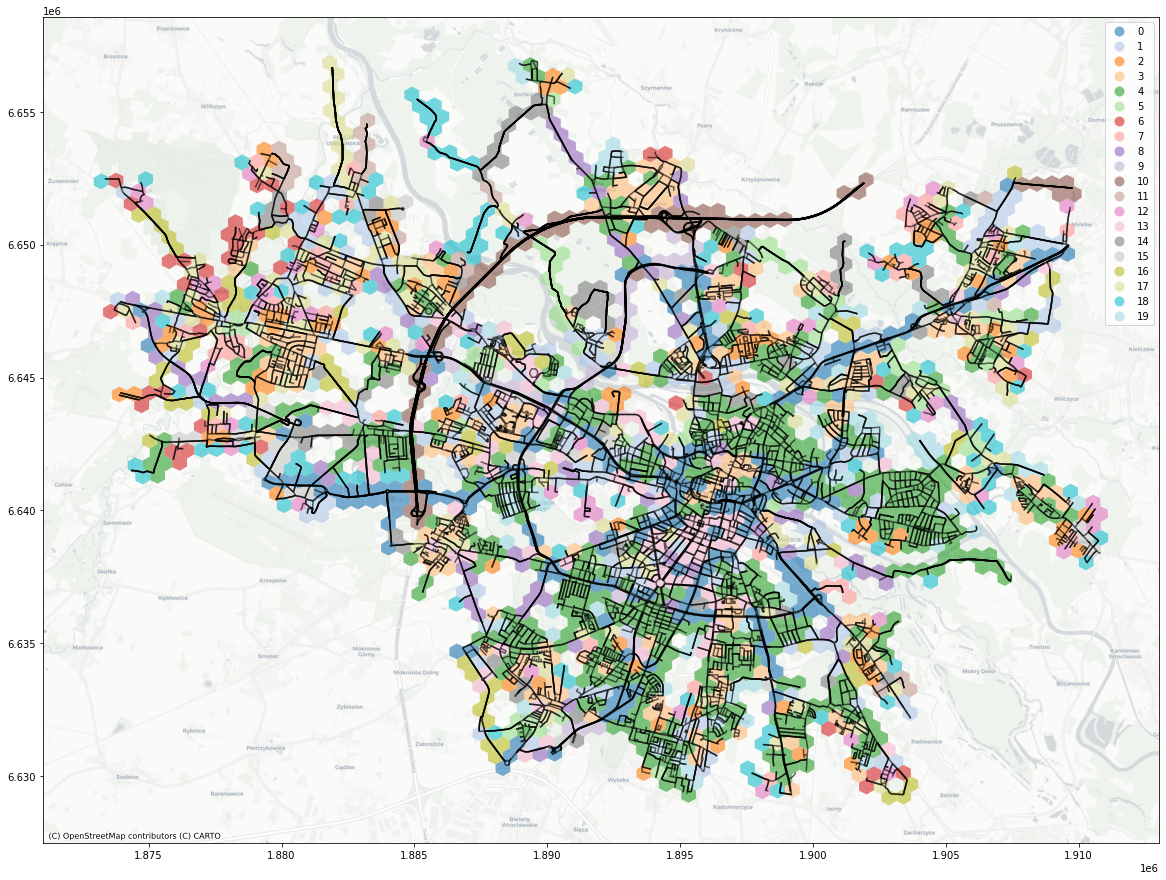

In [33]:
from src.tools.vis_utils import plot_hexagons_map

city = "Wrocław"
plot_hexagons_map(hexagons_clustered[hexagons_clustered["city"] == city], edges_hex[edges_hex["city"] == city], "cluster")

In [35]:
from src.tools.vis_utils import plot_clusters
embedding = reduce_umap(y_df.drop(columns="cluster"), n_components=2, n_neighbors=10, metric="cosine")[0]
embedding["cluster"] = y_df["cluster"]
plot_clusters(embedding)

In [28]:
hex_tfidf_by_cluster = hex_agg_tfidf.join(y_df).groupby(by="cluster")

In [29]:
hex_tfidf_by_cluster_mean = hex_tfidf_by_cluster.mean().reset_index()
hex_tfidf_by_cluster_mean

,cluster,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,...,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,0,0.108935,0.458282,0.124944,0.248181,0.190343,0.086856,0.016293,0.001566,0.000067,...,0.164525,0.195875,-0.327539,-0.007992,-0.412964,-0.082316,-0.534856,-0.044694,0.047933,-0.281040
1,1,0.427126,0.171201,0.045866,0.261512,0.076706,0.027548,0.004792,0.000335,0.000000,...,-0.238005,0.123762,0.109914,0.087641,-0.480741,-0.177327,-0.319546,-0.299233,-0.321889,-0.338272
2,2,0.489519,0.085443,0.027386,0.038789,0.016542,0.009589,0.003730,0.000604,0.000000,...,-0.481760,-0.295989,-0.252577,-0.230025,-0.236748,-0.224769,-0.132845,-0.293415,-0.352110,-0.322720
3,3,0.303112,0.123779,0.035105,0.100124,0.043093,0.022075,0.003738,0.000198,0.000000,...,-0.286686,0.330332,-0.105039,-0.164197,-0.428024,-0.387141,0.085671,-0.004823,-0.320935,-0.200277
4,4,0.367916,0.155173,0.066786,0.128056,0.040340,0.025779,0.003058,0.000192,0.000000,...,-0.374209,0.021085,-0.092753,-0.298779,-0.271159,-0.226195,-0.159822,-0.062202,-0.140928,-0.627870
5,5,0.344236,0.035577,0.039816,0.170972,0.021836,0.009918,0.001376,0.000000,0.000000,...,-0.622873,-0.171797,-0.023019,0.121208,-0.292772,-0.059899,-0.220498,-0.089227,-0.135385,-0.356581
6,6,0.582065,0.001108,0.000000,0.000612,0.000730,0.000359,0.000565,0.000000,0.000000,...,-0.455866,0.191436,0.072229,-0.073039,-0.379145,-0.130349,-0.010025,-0.285950,-0.518516,-0.251109
7,7,0.648779,0.000197,0.000299,0.068980,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.520907,-0.293203,-0.154787,-0.224115,-0.274185,-0.246434,-0.159626,-0.343923,-0.383203,-0.242420
8,8,0.132522,0.029701,0.085155,0.290795,0.106556,0.027238,0.003465,0.000000,0.000000,...,-0.057723,0.111130,0.144267,0.064577,-0.347168,-0.324991,-0.342236,-0.273299,0.224088,-0.357164
9,9,0.041947,0.348509,0.047779,0.164973,0.228449,0.107752,0.020447,0.001325,0.000000,...,0.255728,0.192977,-0.506433,0.005669,0.031858,-0.056784,-0.463020,0.200565,-0.182467,-0.025880


In [45]:
from src.tools.feature_extraction import FEATURESET
for feature_name in FEATURESET.keys():
    fig = px.bar(hex_tfidf_by_cluster_mean, x="cluster", y=list(filter(lambda x: feature_name in x, hex_tfidf_by_cluster_mean.columns)), width=1300, title=feature_name)
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
        )
    )
    fig.show()